In [1]:
# Magics

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Imports

import os, sys, gc
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from collections import Counter

from multiprocessing import Pool, Process

import itertools
from modules.aa_properties import *

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [5]:
aa =   ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
ignore = ["*", "U", "X"]
viruses = ['CMV_StrainAD169', 'YFV_Strain17D', 'HIV-1_StrainHXB2', 'HCV_StrainIsolateH', 'EBV_StrainAG876']
bacteria = ['SHGLsonnei', 'SLMLenteritidis', 'MYPLpneumoniae', 'MYBTsmegmatis', 'SLMLtyphimurium', 
            'YERSpseudotuberculosis', 'YERSenterocolitica', 'CLMDtrachomatis', 'MYPLsynoviae', 'KLEBpneumoniae',
            'CPBTjejuni', 'SHGLflexneri', 'CLOSdificile']
kidera = ["helix.bend.pref", "side.chain.size",
           "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",
           "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]

In [6]:
fdict = {}
for key in os.listdir("data/fasta/"):
    if key.startswith("UP0"):
        fdict[key] = "Human"
    else:
        fdict[key] = key.strip("strain.fasta").strip("_")

In [37]:
def aa_prot_count(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein']+aa)
    aa_dict  = Counter()
    for key in record_dict.keys():
        aa_dict = aa_dict + Counter(record_dict[key].seq)
        for amino in list(aa_dict):
            if amino in ignore:
                del aa_dict[amino]
        df1 = pd.DataFrame.from_dict(aa_dict, orient='index').T / sum(aa_dict.values())
        df1['species'] = species
        df1['protein'] = key
        df = pd.concat([df, df1])
    return df
    
def aa_kidera(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein']+kidera)
    for key in record_dict.keys():
        d = score_sequence(record_dict[key].seq, norm=True)
        df1 = pd.DataFrame(d).T
        df1.columns = kidera
        df1['species'] = species
        df1['protein'] = key
        df = pd.concat([df, df1])
    return df

def aa_hydrophobicity(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein', 'hydrophobicity'])
    for key in record_dict.keys():
        df1 = pd.DataFrame.from_dict({
                'hydrophobicity': score_hydrophobicity_sequence(record_dict[key].seq, norm=True),
                'species': species,
                'protein': key
            }, orient='index').T
        df = pd.concat([df, df1])
    return df

In [8]:
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_prot_count, fdict.items())

pdf = pd.concat(result, axis=0)
pdf = pdf.fillna(0)
pdf = pdf.reset_index(drop=True)

In [13]:
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_kidera, fdict.items())
    
kdf = pd.concat(result, axis=0)
kdf = kdf.reset_index(drop=True)

In [38]:
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_hydrophobicity, fdict.items())
    
hdf = pd.concat(result, axis=0)
hdf = hdf.reset_index(drop=True)

In [43]:
def group_name(name):
    if name in viruses:
        return 'virus'
    elif name in bacteria:
        return 'bacterium'
    elif name in 'Human':
        return 'human'

def cast_pca(df, subset=aa):
    pca = PCA(n_components=2)

    pctd = pca.fit_transform(df[subset])
    pcdf = pd.DataFrame(data = pctd, columns = ['pc1', 'pc2'])
    pcdf['species'] = df.species

    pcdf.species = pcdf.species.apply(lambda x: group_name(x))
    return pcdf

def plot_pca(pcdf):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PC1', fontsize = 15)
    ax.set_ylabel('PC2', fontsize = 15)
    ax.set_title('PCA', fontsize = 20)

    targets = pcdf.species.unique()
    colours = ['r', 'g', 'b']
    for target, colour in zip(targets,colours):
        indicesToKeep = pcdf['species'] == target
        ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
                   , pcdf.loc[indicesToKeep, 'pc2']
                   , c = colour
                   , s = 50)
    ax.legend(targets)
    ax.grid()

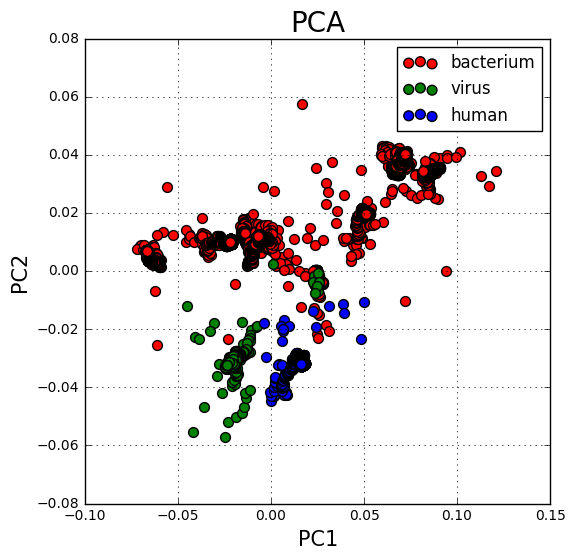

In [45]:
plot_pca(cast_pca(pdf))

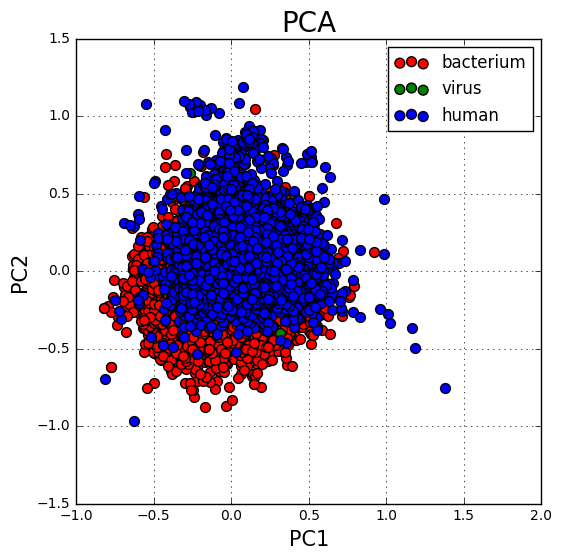

In [44]:
plot_pca(cast_pca(kdf, kidera))

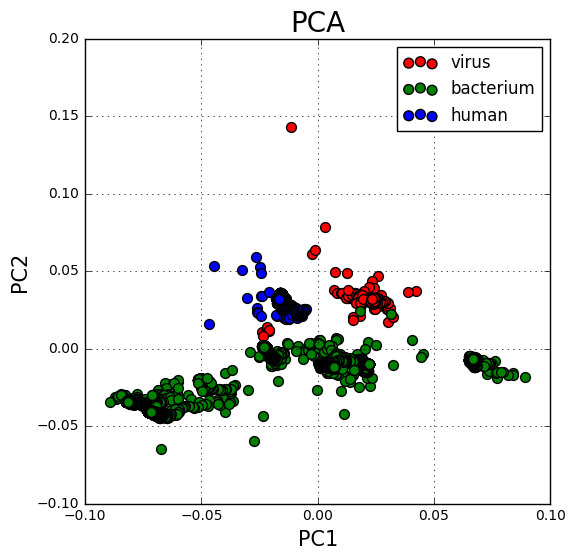

In [26]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

targets = pcdf.species.unique()
colours = ['r', 'g', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = pcdf['species'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = colour
               , s = 50)
ax.legend(targets)
ax.grid()

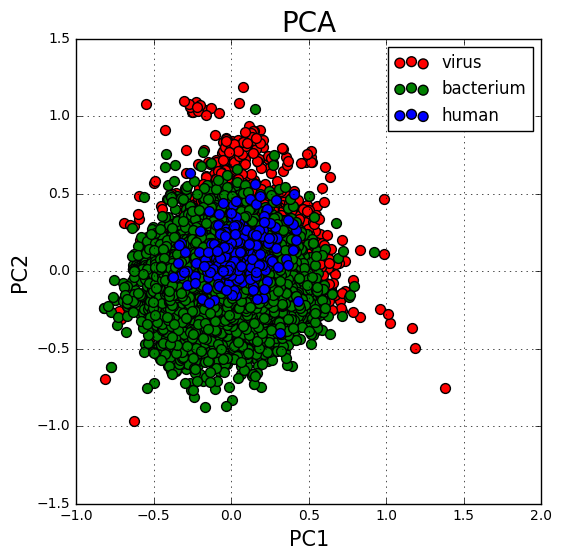

In [78]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

targets = pcdf.species.unique()
colours = ['r', 'g', 'b']
for target, colour in zip(targets[::-1],colours):
    indicesToKeep = pcdf['species'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = colour
               , s = 50)
ax.legend(targets)
ax.grid()

In [46]:
kdf.species = kdf.species.apply(lambda x: group_name(x))

In [61]:
kdf.groupby('species').agg({'hydrophobicity': ['median', 'mean']})

hydrophobicity          
                  median      mean
species                           
bacterium       0.072684  0.055439
human           0.093024  0.092576
virus           0.051103  0.060614

In [52]:
hdf.species = hdf.species.apply(lambda x: group_name(x))

In [58]:
hdf.hydrophobicity = hdf.hydrophobicity.astype('float32')
hdf.dtypes

hydrophobicity    float32
protein            object
species            object
dtype: object

In [62]:
hdf.groupby('species').agg({'hydrophobicity': ['median', 'mean']})

hydrophobicity          
                  median      mean
species                           
bacterium      -0.154521 -0.080530
human          -0.360606 -0.340917
virus          -0.235734 -0.243648

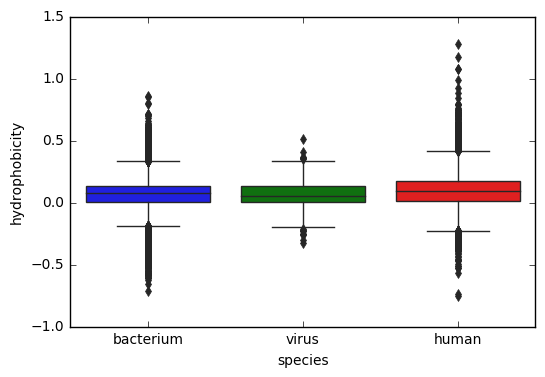

In [48]:
sns.boxplot(x='species', y='hydrophobicity', data=kdf)

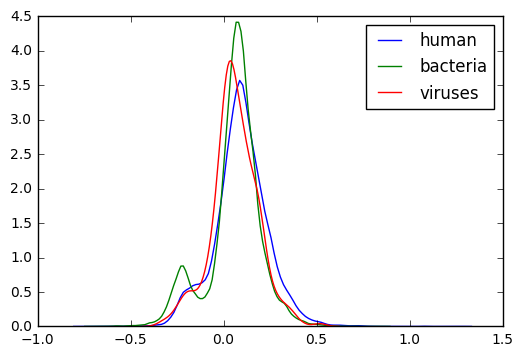

In [67]:
sns.kdeplot(kdf[kdf['species']=='human']['hydrophobicity'], label='human')
sns.kdeplot(kdf[kdf['species']=='bacterium']['hydrophobicity'], label='bacteria')
sns.kdeplot(kdf[kdf['species']=='virus']['hydrophobicity'], label='viruses')

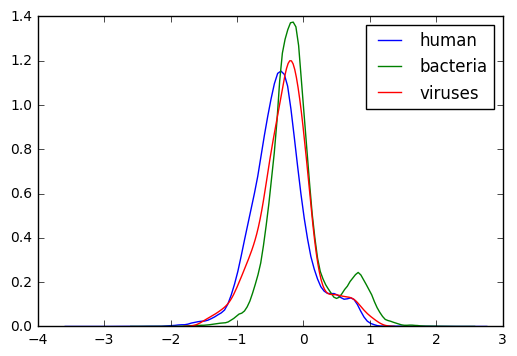

In [68]:
sns.kdeplot(hdf[hdf['species']=='human']['hydrophobicity'], label='human')
sns.kdeplot(hdf[hdf['species']=='bacterium']['hydrophobicity'], label='bacteria')
sns.kdeplot(hdf[hdf['species']=='virus']['hydrophobicity'], label='viruses')

## Train Classifier

In [129]:
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate

fdf = df.copy()
fdf.species = fdf.species.apply(lambda x: group_name(x))
di = {'virus': 0, 'bacterium': 0, 'human': 1}
fdf.replace({'species': di}, inplace=True)
fdf[['species', 'protein']].head()

clf = svm.SVC()

X_train, X_test, y_train, y_test = train_test_split(fdf[aa].values, fdf['species'].values, test_size=.25)

scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
np.mean(scores)

0.99607994377097486

In [133]:
scores

array([ 0.99590905,  0.99590905,  0.99571836,  0.99666952,  0.99619374])